In [1]:
import itertools
import numpy as np
import pandas as pd
import torch
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path

from botorch.utils.multi_objective import pareto
from sklearn.linear_model import LinearRegression

from lambo.utils import FoldxMutation, AMINO_ACIDS, ResidueTokenizer
from lambo.candidate import FoldedCandidate, pdb_to_residues

import warnings
# suppress noisy BioPython warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid', font_scale=1.75)

## Load starting pool of RFP variants
Test a single mutation

In [8]:
rfp_known_structures = pd.read_csv('../lambo/assets/fpbase/rfp_known_structures.csv')
print('valid protein names')
print(rfp_known_structures.Name)

valid protein names
0                    AdRed
1                    DrCBD
2                    DsRed
3                DsRed-Max
4                 DsRed.M1
5                 DsRed.T4
6                    HcRed
7                   HcRed7
8          IrisFP (Orange)
9                 Katushka
10            KikGR1 (Red)
11               KillerRed
12              LSS-mKate1
13              LSS-mKate2
14                 Neptune
15     PSmOrange (Far-red)
16    PSmOrange2 (Far-red)
17                   RCaMP
18                  RFP630
19            Sandercyanin
20                  TagRFP
21                TagRFP-T
22               TagRFP675
23                  Wi-Phy
24                  asulCP
25                cp-mKate
26                 eqFP611
27                 eqFP650
28                 eqFP670
29                  iFP1.4
30                  iFP2.0
31                   laRFP
32               mCRISPRed
33               mCardinal
34                 mCherry
35             mEos2 (Red)
36     m

In [3]:
protein_name = 'DsRed.M1'
pdb_id = rfp_known_structures[rfp_known_structures.Name == protein_name].pdb_id.item().lower()
chain_id = rfp_known_structures[rfp_known_structures.Name == protein_name].longest_chain.item()

work_dir = './tmp'
parent_pdb_path = f'../lambo/assets/foldx/{pdb_id}_{chain_id}/wt_input_Repair.pdb'
tokenizer = ResidueTokenizer()
base_candidate = FoldedCandidate(work_dir, parent_pdb_path, [], 
                                   tokenizer=tokenizer, skip_minimization=True,
                                   chain=chain_id, wild_name=protein_name)

# substitute G at the first position
mutation_list = [base_candidate.new_mutation(seq_idx=0, mutant_residue='G', mutation_type='sub')]
# run FoldX to get new structure
new_candidate = base_candidate.new_candidate(mutation_list)

print(f'---- wild type {protein_name}-{chain_id} ----\n')
print(f'residues: {new_candidate.wild_residue_seq}\n')
print(f'stability: {-new_candidate.wild_total_energy}\n')
print(f'surface area: {new_candidate.wild_surface_area}\n')

print(f'---- mutant {new_candidate.uuid} ----\n')
print(f'residues: {new_candidate.mutant_residue_seq}\n')
print(f'stability: {-new_candidate.mutant_total_energy}\n')
print(f'surface area: {new_candidate.mutant_surface_area}\n')

---- wild type DsRed.M1-A ----

residues: TEDVIKEFMQFKVRMEGSVNGHYFEIEGEGEGKPYEGTQTAKLQVTKGGPLPFAWDILSPQFSKAYVKHPADIPDYMKLSFPEGFTWERSMNFEDGGVVEVQQDSSLQDGTFIYKVKFKGVNFPADGPVMQKKTAGWEPSTEKLYPQDGVLKGEISHALKLKDGGHYTCDFKTVYKAKKPVQLPGNHYVDSKLDITNHNEDYTVVEQYEHAEARHSG

stability: 71.485

surface area: 10385.128377983554

---- mutant 7d013b57203f414fa78798afdf927a15 ----

residues: GEDVIKEFMQFKVRMEGSVNGHYFEIEGEGEGKPYEGTQTAKLQVTKGGPLPFAWDILSPQFSKAYVKHPADIPDYMKLSFPEGFTWERSMNFEDGGVVEVQQDSSLQDGTFIYKVKFKGVNFPADGPVMQKKTAGWEPSTEKLYPQDGVLKGEISHALKLKDGGHYTCDFKTVYKAKKPVQLPGNHYVDSKLDITNHNEDYTVVEQYEHAEARHSG

stability: 70.5536

surface area: 10439.58313654544



## Exhaustively evaluate all 1-edit mutants

Residue substitutions only

In [4]:
# the full mutation sweep is pretty slow (~ 1 day), saving results is recommended
asset_path = Path(f'./assets/{protein_name}-{chain_id}_1-edit_obj-vals.csv')

In [5]:
if os.path.exists(asset_path):
    df = pd.read_csv(asset_path)

else:
    wild_seq, _ = pdb_to_residues(parent_pdb_path, chain_id)
    records = []
    pos_range = range(len(wild_seq))
    for res, pos in itertools.product(AMINO_ACIDS, pos_range):
        mutation_list = [base_candidate.new_mutation(pos, res)]
        print(mutation_list[0])
        candidate = base_candidate.new_candidate(mutation_list)
        records.append({
            'seq_idx': pos,
            'wt_residue': wild_seq[pos],
            'mutant_residue': res,
            'mutant_uuid': candidate.uuid,
            'mutant_surface_area': candidate.mutant_surface_area,
            'mutant_total_energy': candidate.mutant_total_energy
        })

        # comment out to run full loop
        if pos == 10:
            break
            
    df = pd.DataFrame(records)
    os.makedirs(asset_path.parent, exist_ok=True)
    df.to_csv(asset_path, index=None)

## Evaluate fitness landscape

In [6]:
# post-processing
mutant_surface_area = torch.tensor(df.mutant_surface_area)
sa_min = mutant_surface_area.min()
sa_range = mutant_surface_area.max() - sa_min
x_data = 2 * (mutant_surface_area - sa_min) / sa_range - 1

mutant_stability = -torch.tensor(df.mutant_total_energy)
stab_min = mutant_stability.min()
stab_range = mutant_stability.max() - stab_min
y_data = 2 * (mutant_stability - stab_min) / stab_range - 1

obj = torch.stack([x_data, y_data], dim=-1)
pareto_mask = pareto.is_non_dominated(obj)

ref_x = 2 * (base_candidate.wild_surface_area - sa_min) / sa_range - 1
ref_y = 2 * (-base_candidate.wild_total_energy - stab_min) / stab_range - 1

# fit OLS model
lin_reg = LinearRegression().fit(x_data.view(-1, 1), y_data)
r_squared = lin_reg.score(x_data.view(-1, 1), y_data)
reg_x = np.linspace(-1, 1, 100)
reg_y = lin_reg.coef_ * reg_x + lin_reg.intercept_

# detailed OLS results
X2 = sm.add_constant(x_data.view(-1, 1).numpy())
est = sm.OLS(y_data.numpy(), X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     6.525
Date:                Tue, 22 Mar 2022   Prob (F-statistic):             0.0310
Time:                        11:53:32   Log-Likelihood:                -6.5436
No. Observations:                  11   AIC:                             17.09
Df Residuals:                       9   BIC:                             17.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2748      0.147      1.872      0.0

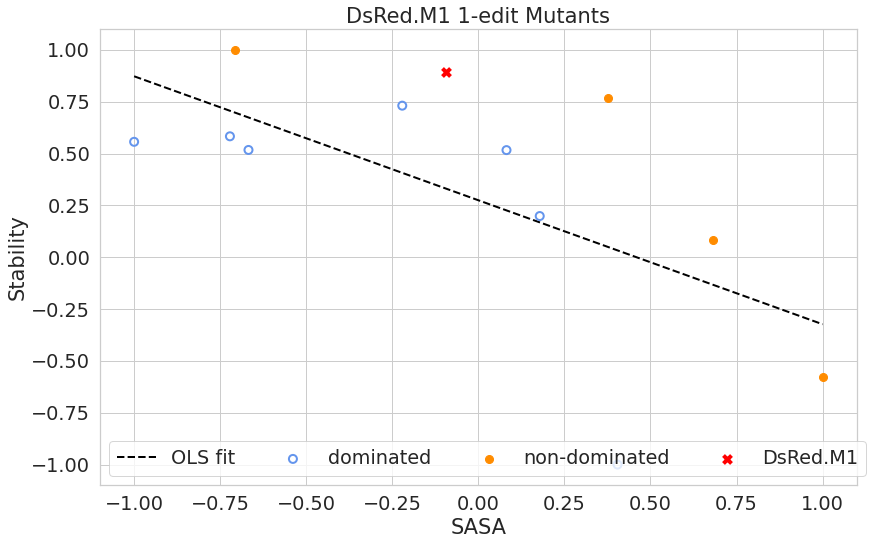

In [7]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1)

ax.plot(reg_x, reg_y, color='black', linestyle='--', linewidth=2, zorder=1, label='OLS fit')
ax.scatter(x_data[~pareto_mask], y_data[~pareto_mask], linewidth=2,
           s=64, facecolors='none', edgecolors='cornflowerblue', zorder=2, label='dominated')
ax.scatter(x_data[pareto_mask], y_data[pareto_mask], 
           s=64, label='non-dominated', color='darkorange', zorder=3)
ax.scatter(ref_x, ref_y, color='red', s=64, marker='x', label=protein_name,
           linewidth=4, zorder=2)

ax.set_xlabel('SASA')
ax.set_ylabel('Stability')
ax.set_title(f'{protein_name} 1-edit Mutants')
ax.legend(ncol=4)
plt.tight_layout()

# plt.savefig(f'./figures/{protein_name}-{chain_id}_1-edit_obj-vals.pdf')

###### 